In [1]:
from data_loader import get_loader
from PIL import Image
import torch
import torchvision.transforms as transforms
import torch.utils.data as data

In [22]:
# Training Configuration
image_root = "./../../../datasets/cs253-wi20-public/ShapeNetRendering/"
point_cloud_root = "./../../../datasets/cs253-wi20-public/ShapeNet_pointclouds/"


batch_size = 4
shuffle = True
num_workers = 8
use_2048 = True
img_size = 100
transform = transforms.Compose([transforms.Resize(img_size,interpolation=2),transforms.CenterCrop(img_size)])


In [23]:
# p = './../../../datasets/cs253-wi20-public/ShapeNetRendering/02691156/10155655850468db78d106ce0a280f87/rendering/00.png'

In [24]:
data_loader = get_loader(image_root, point_cloud_root, use_2048, transform, batch_size, shuffle, num_workers)

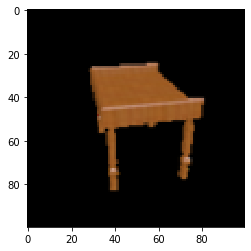

In [33]:
from matplotlib import pyplot as plt
import numpy as np

for i, (images, point_clouds) in enumerate(data_loader):
    # Show image and print point cloud.
    #     print(type(image))
#     print(images.size())
    
    image = images[0]
    pc = point_clouds[0]
    
    plt.imshow(image)

    
    break
    

In [1]:
from split_data import split_data, read_from_file

In [2]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [3]:
split_data(train_ratio, val_ratio, test_ratio, overrideFiles = False)

In [4]:
import numpy as np

l = np.arange(1, 10, 1)

s = set(l)
print(s)

{1, 2, 3, 4, 5, 6, 7, 8, 9}


In [5]:
p = np.arange(11, 20, 1)

lp = [(l[t],p[t]) for t in range(len(l))]
print(lp)

[(1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 16), (7, 17), (8, 18), (9, 19)]


In [6]:
lps = set(lp)

(1,10) in lps

False

In [8]:
train_data = read_from_file('train_data.txt')

In [10]:
for i, s in train_data:
    print(i), print(s)
    break
    

02958343
f6d7cd8a000997b1aa69dfdc5532bb13


In [2]:

import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from chamfer_distance import ChamferDistance
from torch.autograd import Variable
import glob
import torch.nn.functional as F
from models import Encoder, Tnet, Decoder

In [3]:
l = glob.glob("/datasets/cs253-wi20-public/ShapeNet_pointclouds/*/*/*2048.npy")

class PointCloudDataset(Dataset):

    def __init__(self, lis= None):
        
        point_clouds = []
        for file_name in lis:

            points = np.load(file_name)
            point_clouds.append(points)

        self.point_clouds = np.array(point_clouds, dtype='float64')
        self.point_clouds = np.transpose(self.point_clouds, (0, 2, 1))
        
    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        return self.point_clouds[idx]

In [4]:
point_cloud_dataset = PointCloudDataset(l)
dataloader = DataLoader(point_cloud_dataset, batch_size=32, shuffle=True)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

inp  = next(iter(dataloader)).float()

baseline = torch.load('best-Baseline.pt')

baseline = baseline.cuda()

# train_output = enc(inp.cuda().float())
out= baseline(inp.cuda().float())
for i in range(4):
    ax = fig.add_subplot(2, 4, i+1, projection='3d')
    data = inp[i].numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='b', label='ground truth')
    data = out[i].cpu().detach().numpy()
    ax = fig.add_subplot(2, 4, i+5, projection='3d')
    ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='r', label='decoded')
    
ax.legend()
plt.show()

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 3 3 1 1, but got 3-dimensional input of size [32, 3, 2048] instead

<Figure size 432x288 with 0 Axes>

In [1]:
import glob

image_root = "/datasets/cs253-wi20-public/ShapeNetRendering/"

syn_list = glob.glob(image_root+"*/*/rendering/*.png")


In [4]:
import random
from PIL import Image

N = len(syn_list)
image = Image.open(syn_list[random.randint(0, N-1)]).convert('RGB')


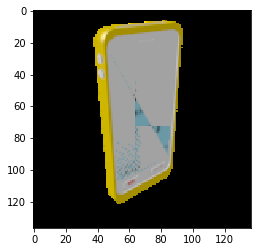

In [7]:
import matplotlib.pyplot as plt


plt.imshow(image)
plt.show()

In [8]:
point_cloud_root = "/datasets/cs253-wi20-public/ShapeNet_pointclouds/"

pc_list = glob.glob(point_cloud_root+"*/*/*2048.npy")


In [9]:
len(pc_list)

43784

In [12]:
import numpy as np

index = 0

point_cloud = np.load(pc_list[index])

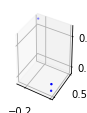

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(2, 4, 1, projection='3d')

data= point_cloud

ax.scatter(data[0], data[1], data[2], zdir='z', s=2, c='b', label='ground truth')


In [14]:
img_pc = Image.fromarray(point_cloud, 'RGB')

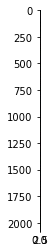

In [16]:
plt.imshow(img_pc)
plt.show()

In [17]:
point_cloud.shape

(2048, 3)

In [1]:
from __future__ import print_function
import argparse
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from datasets import PartDataset
import torch.nn.functional as F
import torch.cuda as cuda
from pic2points_model import pic2points
from torch.nn.parallel import DataParallel
from torch.autograd import Variable
import torch
from data_loader import XDataset, get_loader
from split_data import read_from_file, write_to_file, split_data
import time
from visualize import Visualize

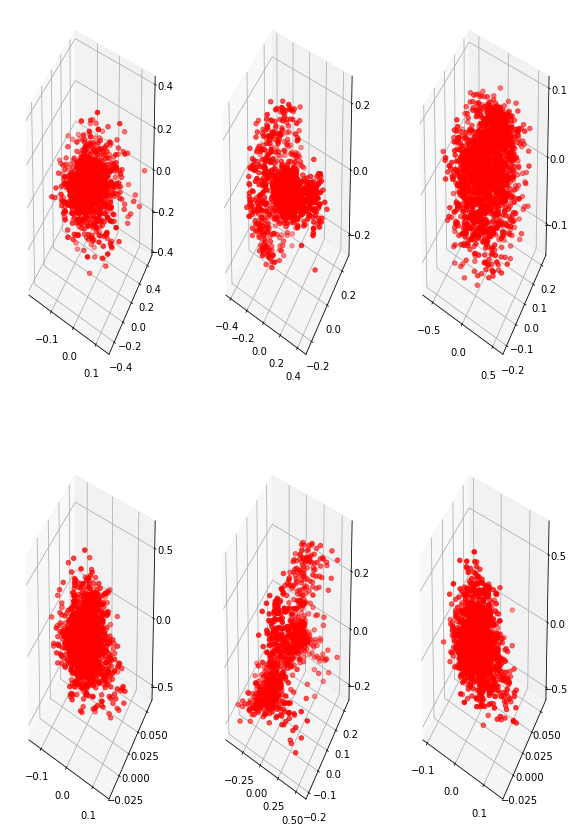

In [4]:


# Decide on GPU or CPU
# if torch.cuda.is_available():
#     gpu_or_cpu = torch.device('cuda')
# else:
gpu_or_cpu = torch.device('cpu')

image_root = "/datasets/cs253-wi20-public/ShapeNetRendering/"
point_cloud_root = "/datasets/cs253-wi20-public/ShapeNet_pointclouds/"

num_epochs = 20
batch_size = 64
shuffle = True
num_workers = 8
use_2048 = True
img_size = 227 # I don't know why, but this has to be 227!
learning_rate = 5e-4
num_points = 2500
transform = transforms.Compose([transforms.Resize(img_size,interpolation=2),
                                transforms.CenterCrop(img_size),transforms.ToTensor()])



path_test = 'test_data.txt'
test_data = read_from_file(path_test)

test_data_loader = get_loader(image_root, point_cloud_root, test_data, use_2048, 
                         transform, batch_size, shuffle, num_workers)


model = torch.load('Baseline_DL_Vis.pt', map_location=torch.device('cpu'))
model.eval()




for i, (image, point_cloud) in enumerate(test_data_loader):
    image, point_cloud = Variable(image, requires_grad = False), Variable(point_cloud, requires_grad = False)

    image, point_cloud = image.float().to(device=gpu_or_cpu), point_cloud.float().to(device=gpu_or_cpu)
    pred = model(image)
#     dist1, dist2 = chamferDist(pred, point_cloud)
#     loss = (torch.mean(dist1)) + (torch.mean(dist2))

#     print('pred size = ', pred.size())
    pred = pred.to('cpu')
    

    out = []

    for p in pred:
        out.append(p.detach().numpy())

#     print('type(out) = ', type(out))





    # Visualize the prediction
#     print('asdf')
    Visualize(out).ShowRandom()
    
    break

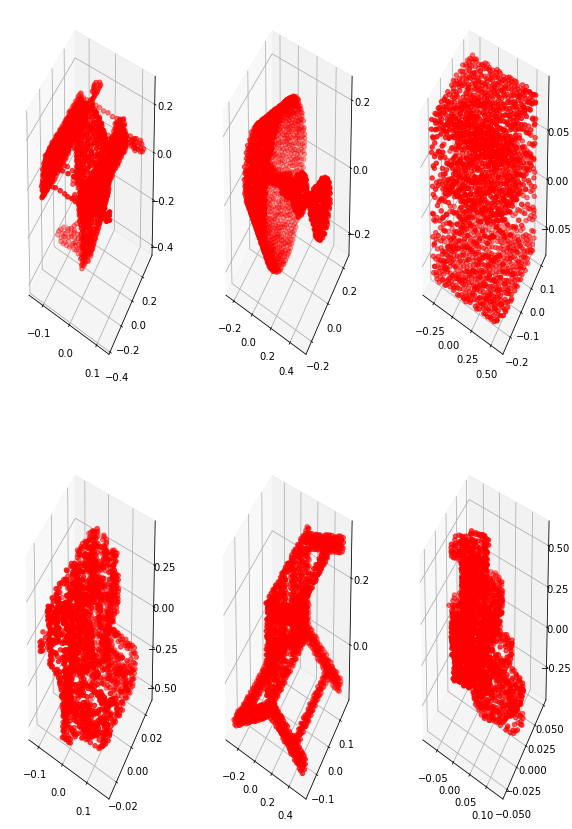

In [5]:
point_cloud = point_cloud.to('cpu')

out_p = []

for p in point_cloud:
    out_p.append(p.detach().numpy())
Visualize(out_p).ShowRandom()

In [4]:
import zipfile

In [5]:
zf = zipfile.ZipFile('pix3d.zip')

In [8]:
with zipfile.ZipFile('pix3d.zip', 'r') as file:
    file.printdir()

File Name                                             Modified             Size
img/                                           2018-04-08 15:00:20            0
img/bookcase/                                  2018-04-09 21:41:04            0
img/bookcase/0257.jpg                          2018-04-08 14:55:42        46909
img/bookcase/0191.jpg                          2018-04-08 14:56:06        41590
img/bookcase/0140.jpg                          2018-04-08 14:54:44       159687
img/bookcase/0286.jpg                          2018-04-08 14:54:54       368121
img/bookcase/0018.jpg                          2018-04-08 14:54:52         4946
img/bookcase/0064.jpg                          2018-04-08 14:55:48        33121
img/bookcase/0162.jpeg                         2018-04-08 14:55:42        25315
img/bookcase/0063.jpg                          2018-04-08 14:56:22       277078
img/bookcase/0094.png                          2018-04-08 14:55:52       696710
img/bookcase/0250.jpg                   

img/chair/1820.jpg                             2018-04-08 14:54:26       120653
img/chair/3199.jpg                             2018-04-08 14:54:18       111911
img/chair/1978.jpg                             2018-04-08 14:54:32        33800
img/chair/3529.jpg                             2018-04-08 14:54:04         9433
img/chair/2369.jpg                             2018-04-08 14:54:06        25277
img/chair/2089.png                             2018-04-08 14:53:44        15487
img/chair/2708.jpg                             2018-04-08 14:54:26        10915
img/chair/3148.jpg                             2018-04-08 14:54:28       158575
img/chair/2998.jpg                             2018-04-08 14:53:46       213590
img/chair/1358.jpg                             2018-04-08 14:54:32      1926802
img/chair/0518.jpg                             2018-04-08 14:53:50      1805558
img/chair/0179.jpg                             2018-04-08 14:54:22      1122701
img/chair/1739.jpg                      

img/sofa/0467.jpg                              2018-04-08 14:55:14       143218
img/sofa/0815.jpg                              2018-04-08 14:55:40       516224
img/sofa/1646.jpg                              2018-04-08 14:56:32        28830
img/sofa/0298.jpg                              2018-04-08 14:55:10       111703
img/sofa/1738.png                              2018-04-08 14:56:08        63872
img/sofa/1068.jpg                              2018-04-08 14:56:22        69798
img/sofa/0628.jpg                              2018-04-08 14:55:26       197442
img/sofa/0249.jpg                              2018-04-08 14:56:22       156072
img/sofa/1409.jpg                              2018-04-08 14:56:20       263601
img/sofa/0869.jpg                              2018-04-08 14:56:20       135626
img/sofa/0104.png                              2018-04-08 14:55:04       965707
img/sofa/1303.jpg                              2018-04-08 14:55:36        73954
img/sofa/0931.jpg                       

img/wardrobe/0122.jpg                          2018-04-08 14:55:24         8767
img/wardrobe/0235.jpg                          2018-04-08 14:55:14         3324
img/wardrobe/0033.jpg                          2018-04-08 14:54:58        51845
img/wardrobe/0226.png                          2018-04-08 14:55:34        53872
img/wardrobe/0200.jpg                          2018-04-08 14:54:44        34053
img/wardrobe/0117.jpg                          2018-04-08 14:56:10         8333
img/wardrobe/0207.jpg                          2018-04-08 14:55:58        14867
img/wardrobe/0110.jpg                          2018-04-08 14:55:12        79887
img/wardrobe/0048.jpg                          2018-04-08 14:54:42        32028
img/wardrobe/0099.jpg                          2018-04-08 14:54:54        15194
img/wardrobe/0034.jpg                          2018-04-08 14:54:52       113538
img/wardrobe/0209.jpg                          2018-04-08 14:55:58       514514
img/wardrobe/0046.jpg                   

mask/chair/0831.png                            2018-04-08 14:53:38        32647
mask/chair/0443.png                            2018-04-08 14:54:04        22740
mask/chair/1203.png                            2018-04-08 14:53:48        23450
mask/chair/2316.png                            2018-04-08 14:54:28         2624
mask/chair/3556.png                            2018-04-08 14:54:06         1479
mask/chair/1662.png                            2018-04-08 14:54:30         4910
mask/chair/0785.png                            2018-04-08 14:53:10        43742
mask/chair/0022.png                            2018-04-08 14:54:34         6662
mask/chair/3690.png                            2018-04-08 14:54:02         4364
mask/chair/3137.png                            2018-04-08 14:54:26          668
mask/chair/2777.png                            2018-04-08 14:53:56         1447
mask/chair/2001.png                            2018-04-08 14:54:14         2850
mask/chair/3641.png                     

mask/sofa/1525.png                             2018-04-08 14:55:28         1675
mask/sofa/1282.png                             2018-04-08 14:55:44         1288
mask/sofa/0365.png                             2018-04-08 14:56:12         1326
mask/sofa/0413.png                             2018-04-08 14:55:10         2551
mask/sofa/0861.png                             2018-04-08 14:56:30         2484
mask/sofa/1253.png                             2018-04-08 14:55:46         3933
mask/sofa/1195.png                             2018-04-08 14:56:04          609
mask/sofa/1632.png                             2018-04-08 14:55:26         3775
mask/sofa/0072.png                             2018-04-08 14:56:16         1566
mask/sofa/0939.png                             2018-04-08 14:55:22         1324
mask/sofa/0828.png                             2018-04-08 14:55:36         1935
mask/sofa/1846.png                             2018-04-08 14:55:40         1172
mask/sofa/1434.png                      

model/chair/SS_032/voxel.mat                   2018-04-07 01:01:56        18170
model/chair/SS_148/                            2018-04-12 22:27:30            0
model/chair/SS_148/model.obj                   2018-04-11 02:05:12      3452264
model/chair/SS_148/3d_keypoints.txt            2018-04-08 00:48:34          399
model/chair/SS_148/voxel.mat                   2018-04-07 00:39:24        19124
model/chair/IKEA_JULES_1/                      2018-04-07 23:51:06            0
model/chair/IKEA_JULES_1/model_-0.598593651208_-0.0607107699809.obj 2018-04-08 00:49:02       173156
model/chair/IKEA_JULES_1/model_-0.375894284877_0.0105080306113.obj 2018-04-08 00:47:18       173172
model/chair/IKEA_JULES_1/model_-0.807786743515_-0.0526778029753.obj 2018-04-08 00:47:18       173141
model/chair/IKEA_JULES_1/model_-0.5459643455_0.0747639463779.obj 2018-04-08 00:48:26       173201
model/chair/IKEA_JULES_1/model_-0.62676196165_-0.00126018003796.obj 2018-04-08 00:48:28       173166
model/chair/IKEA_JU

In [23]:
import glob, os

In [25]:
filenames = []
paths = []

for filename in os.listdir('img/bed'):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        filenames.append(filename)
        paths.append(os.path.join('img/bed', filename))

In [37]:
mask_paths = []

idx = 0
for filename in filenames:
    for file in os.listdir('mask/bed'):
        image_id = filenames[idx].split('.')[0]
        
        if file.startswith(image_id):
            mask_paths.append(os.path.join('mask/bed', file))
            idx += 1
            break

In [38]:
len(mask_paths), len(paths)

(979, 979)

In [39]:
mask_paths[10], paths[10]

('mask/bed/0315.png', 'img/bed/0315.jpg')

In [12]:
from PIL import Image

In [13]:
img_size = 227

transform = transforms.Compose([transforms.Resize(img_size,interpolation=2),
                                    transforms.CenterCrop(img_size),transforms.ToTensor()])

In [42]:
from matplotlib import pyplot as plt
out = []



for idx in range(len(paths)):
    image_path = paths[idx]
    mask_path = mask_paths[idx]
    image = Image.open(image_path).convert('RGB')
    
    mask = Image.open(mask_path)
    
#     plt.imshow(image)
    
    
    image = transform(image)
    mask = transform(mask)
    
    # Multiply
    print(image.size(), mask.size())
    
    image = image* mask
#     break
    
    image = image.float().to(device=gpu_or_cpu)
    
    
    # Reshape to include batch size
    image = image.unsqueeze(0)
    
    
    pred = model(image)
    
    pred = pred.to('cpu')
    
    for p in pred:
        out.append(p.detach().numpy())
    
    if len(out) == 10:
        break
    
    

torch.Size([3, 227, 227]) torch.Size([1, 227, 227])
torch.Size([3, 227, 227]) torch.Size([1, 227, 227])
torch.Size([3, 227, 227]) torch.Size([1, 227, 227])
torch.Size([3, 227, 227]) torch.Size([1, 227, 227])
torch.Size([3, 227, 227]) torch.Size([1, 227, 227])
torch.Size([3, 227, 227]) torch.Size([1, 227, 227])
torch.Size([3, 227, 227]) torch.Size([1, 227, 227])
torch.Size([3, 227, 227]) torch.Size([1, 227, 227])
torch.Size([3, 227, 227]) torch.Size([1, 227, 227])
torch.Size([3, 227, 227]) torch.Size([1, 227, 227])


Shape is

(2500, 3)
Shape is

(2500, 3)
Shape is

(2500, 3)
Shape is

(2500, 3)
Shape is

(2500, 3)
Shape is

(2500, 3)


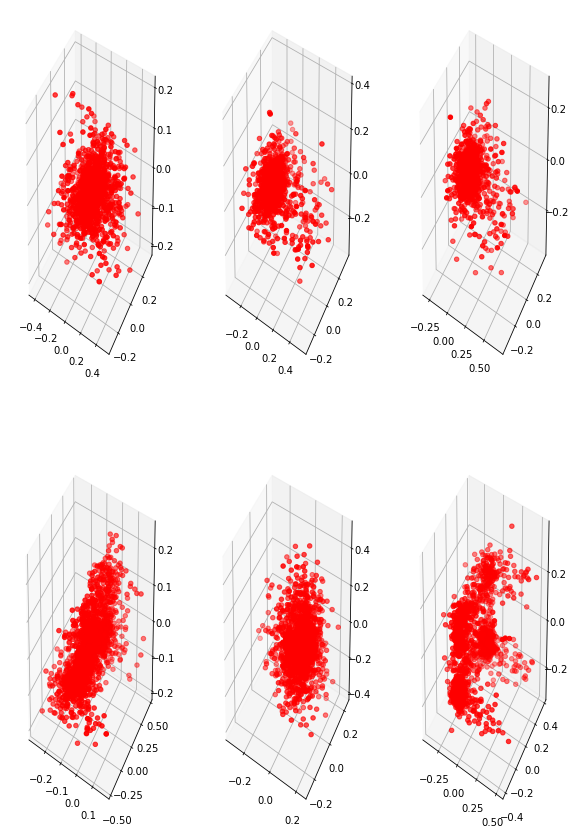

In [43]:
Visualize(out).ShowRandom()

In [44]:
mask_paths[:10]

['mask/bed/0369.png',
 'mask/bed/0089.png',
 'mask/bed/0708.png',
 'mask/bed/0126.png',
 'mask/bed/0681.png',
 'mask/bed/0935.png',
 'mask/bed/0547.png',
 'mask/bed/0596.png',
 'mask/bed/0231.png',
 'mask/bed/0650.png']